In [13]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
plt.rcParams.update({"text.usetex": True,
                     'text.latex.preamble' : r'\usepackage{amsmath,amssymb}',
                    })
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import seaborn as sns
import numpy as np
import scipy.stats as stats
import json
import pitchtypes

import utils
utils.set_fifth_range(14) # 2 diatonics above and below center = 2*2*7 + 1

import os.path as path
from os import mkdir

# Plots

Plots of the model parameters for use in the paper.

## Loading Data

In [2]:
# load the data
def load_data(name):
    # chord types
    #df = utils.load_csv(path.join('data', name + '.tsv'))
    #sizes = df.groupby(['chordid', 'label']).size()
    #type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    #chordtypes = type_counts.index.tolist()
    
    # parameters
    with open(name+'_params.json', 'r') as f:
        data = json.load(f)
    
    return {k:np.array(v) for k,v in data['params'].items()}, np.array(data['chordtypes'], dtype='object')

In [3]:
dcml_params, dcml_chordtypes = load_data('dcml')
wiki_params, wiki_chordtypes = load_data('wikifonia')
fifth_range = 14

In [4]:
dcml_chordtypes_alt = np.array(
    ["major", "minor", "dominant-7th", "diminished",
     "full-diminished", "minor-7th", "half-diminished", "major-7th",
     "augmented", "German-6th", "Italian-6th", "French-6th",
     "minor-major-7th", "augmented-7th"],
    dtype="object")
wiki_chordtypes_alt = np.array(
    ["major", "dominant-7th", "minor", "minor-7th", "major-7th",
     "dominant-9th", "major-6th", "diminished", "minor-6th",
     "half-diminished", "suspended-4th", "full-diminished",
     "augmented-7th", "augmented", "dominant-13th", "minor-9th",
     "major-9th", "dominant-11th", "minor-major-7th", "power",
     "suspended-2nd", "minor-11th", "major-13th", "minor-13th"],
    dtype="object")
chordtypes_common = np.array(
    ["major", "minor", "dominant-7th", "diminished",
     "full-diminished", "minor-7th", "half-diminished", "major-7th",
     "augmented", "minor-major-7th", "augmented-7th"],
    dtype="object")
chordtypes_all = np.array(['major', 'minor', 'dominant-7th', 'diminished', 'full-diminished',
       'minor-7th', 'half-diminished', 'major-7th', 'augmented',
       'German-6th', 'Italian-6th', 'French-6th', 'minor-major-7th',
       'augmented-7th', 'dominant-9th', 'major-6th', 'minor-6th',
       'suspended-4th', 'dominant-13th', 'minor-9th',
       'major-9th', 'dominant-11th', 'power',
       'suspended-2nd', 'minor-11th', 'major-13th', 'minor-13th'],
      dtype=object)

In [5]:
def saveplot(name, fig):
    fig.savefig(path.join('plots', name+'.pdf'))

## Posterior Plots

In [6]:
# posterior of 'rate_notes'
def plot_note_rate_post(ax, params, width=None):
    alpha = params['alpha_rate_notes']
    beta = params['beta_rate_notes']
    mean, var = stats.gamma.stats(alpha, scale=1/beta)
    print(f"{mean=}, {var=}")
    
    if width == None:
        limits = stats.gamma.interval(.999999, alpha, scale=1/beta)
    else:
        limits = (mean-width/2, mean+width/2)
    
    x = np.linspace(limits[0], limits[1], 400)
    y = stats.gamma.pdf(x, alpha, scale=1/beta)
    ax.plot(x, y)
    ax.set_xlim(limits)
    ax.set_xlabel('$\lambda$')

def plot_note_rates(params1, params2, width=None):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,3), sharey=True)
    plot_note_rate_post(ax1, params1, width=width)
    ax1.set_title("DCML")
    plot_note_rate_post(ax2, params2, width=width)
    ax2.set_title("Wikifonia")
    fig.tight_layout()
    return fig

mean=array(5.57076385), var=array(3.54925369e-05)
mean=array(2.40146178), var=array(9.34023932e-06)


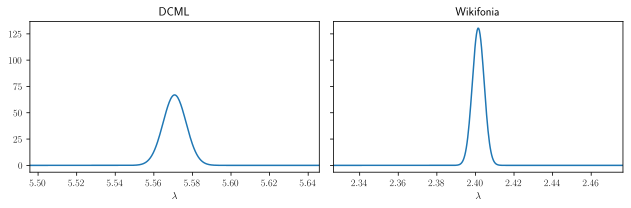

In [7]:
note_rates = plot_note_rates(dcml_params, wiki_params, width=0.15)
saveplot('note_rates', note_rates)

In [115]:
# zoom effect
def connect_bbox(bbox1, bbox2, bbox3,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
        }

    c1 = BboxConnector(bbox1, bbox3, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox3, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)
    bbox_patch1.set_clip_on(False)
    bbox_patch2.set_clip_on(False)

    p = BboxConnectorPatch(bbox1, bbox3,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p
    
def zoom_effect(ax1, ax2, xmin, xmax, **kwargs):
    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, -0.12)
    bbox2 = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)
    mybbox3 = TransformedBbox(bbox2, trans2)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}#, "fc": "none"}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2, mybbox3,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect2(ax1, ax2, xmin, xmax):
    
    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)
    bbox = Bbox.from_extents(xmin, 0, xmax, -0.12)
    bbox2 = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)
    mybbox3 = TransformedBbox(bbox2, trans2)

    prop_patches = {"ec": "none", "alpha": 0.2}
    prop_lines = {"ec": 'black', 'fc': 'none', 'alpha': 0.5}

    c1 = BboxConnector(mybbox1, mybbox3, loc1=3, loc2=2, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(mybbox1, mybbox3, loc1=4, loc2=1, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(mybbox1, **prop_patches)
    bbox_patch2 = BboxPatch(mybbox2, **prop_patches)
    bbox_patch3 = BboxPatch(mybbox3, **prop_lines)
    bbox_patch1.set_clip_on(False)
    bbox_patch2.set_clip_on(False)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(bbox_patch3)
    ax2.add_patch(c1)
    ax2.add_patch(c2)

    return c1, c2, bbox_patch1, bbox_patch2

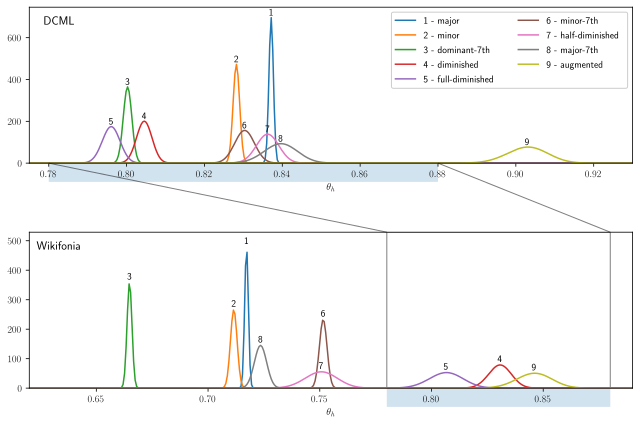

In [116]:
# posterior of 'p_is_chordtone'
def plot_p_ict(ax, params, harmtypes, indices, lower=0, upper=1):
    alphas = np.array(params["alpha_p_ict"])[indices]
    betas  = np.array(params["beta_p_ict"])[indices]
    x = np.linspace(lower, upper, 400)
    y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(alphas, betas)]).transpose()
    ax.plot(x,y)
    
    meansx = [stats.beta.mean(a,b) for a,b in zip(alphas,betas)]
    meansy = [stats.beta.pdf(x,a,b) for (x,a,b) in zip(meansx,alphas,betas)]
    for i,(xi,yi) in enumerate(zip(meansx,meansy)):
        ax.text(xi, yi+10, str(i+1), ha='center')
    
    ax.set_xlabel("$\\theta_h$")
    ax.set_xlim((lower, upper))
    ax.set_ylim((0,np.array(meansy).max()+50))

def plot_p_icts():
    fig, (ax1, ax2) = plt.subplots(2, figsize=(9,6))
    plot_p_ict(ax1, dcml_params, dcml_chordtypes_alt, [0,1,2,3,4,5,6,7,8],
               lower=0.775, upper=0.93)
    ax1.set_title('DCML', x=0.05, y=0.85)
    plot_p_ict(ax2, wiki_params, wiki_chordtypes_alt, [0,2,1,7,11,3,9,4,13],
               lower=0.62, upper=0.89)
    ax2.set_title('Wikifonia', x=0.05, y=0.85)
    ax1.legend([f"{i+1} - {dcml_chordtypes_alt[i]}" for i in range(9)],
               loc='upper right', ncol=2, framealpha=1)
    zoom_effect2(ax1,ax2,0.78,0.88)
    fig.tight_layout()
    return fig

icts = plot_p_icts()
saveplot('icts', icts)

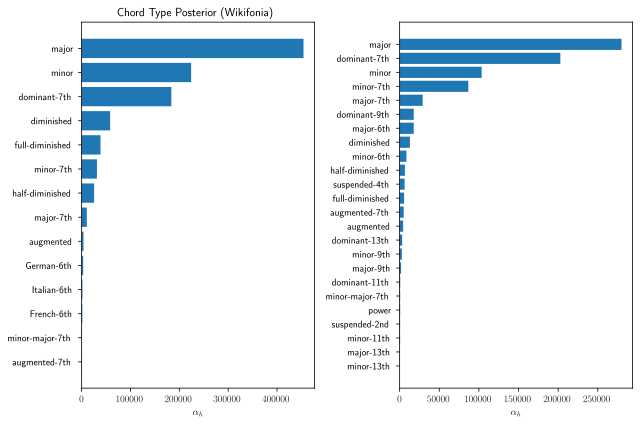

In [50]:
# posterior of chord type probabilities
def plot_chord_type_dist(ax, params, labels):
    alphas = params['params_p_harmony']
    ax.barh(np.arange(len(alphas))[::-1], alphas, tick_label=labels)
    ax.set_xlabel("$\\alpha_h$")
    
def plot_chord_type_dists():
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,6))
    plot_chord_type_dist(ax1, dcml_params, dcml_chordtypes_alt)
    ax1.set_title("Chord Type Posterior (DCML)")
    plot_chord_type_dist(ax2, wiki_params, wiki_chordtypes_alt)
    ax1.set_title("Chord Type Posterior (Wikifonia)")
    fig.tight_layout()
    return fig
    
type_dist = plot_chord_type_dists()
saveplot('type_dist', type_dist)

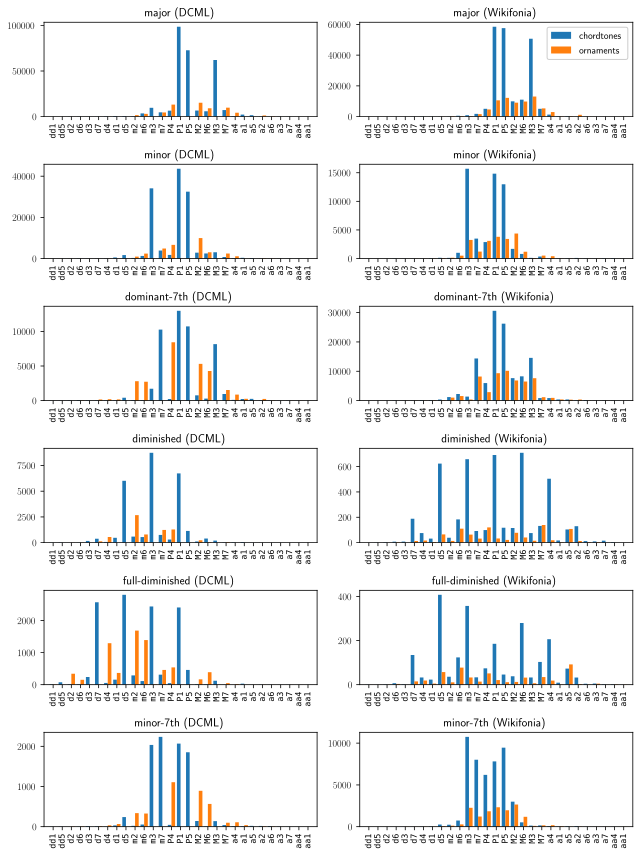

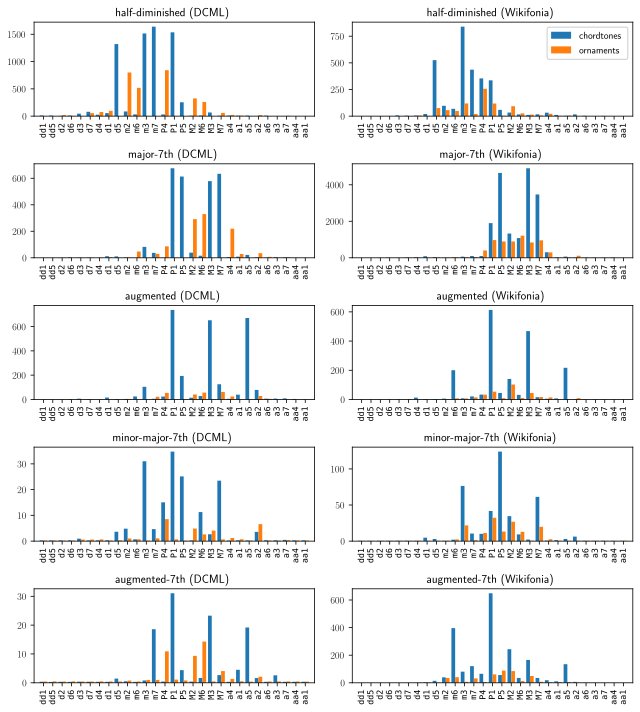

In [10]:
interval_labels = ['dd1', 'dd5', 'd2', 'd6', 'd3', 'd7', 'd4',
                   'd1', 'd5', 'm2', 'm6', 'm3', 'm7', 'P4',
                   'P1', 'P5', 'M2', 'M6', 'M3', 'M7', 'a4',
                   'a1', 'a5', 'a2', 'a6', 'a3', 'a7', 'aa4', 'aa1']

def plot_profile(ax, params, i, name):
    chordtones = params['params_p_chordtones'][i]
    ornaments = params['params_p_ornaments'][i]
    #labels = [str(pitchtypes.SpelledIntervalClass(i)) for i in range(-fifth_range, fifth_range+1)]
    #labels = np.arange(-fifth_range, fifth_range+1)
    labels = interval_labels
    x = np.arange(2*fifth_range+1)
    width = 0.4
    ax.bar(x - width/2, chordtones, width, label='chord tones')
    ax.bar(x + width/2, ornaments, width, label='ornaments')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation='vertical', va='top', family='monospace', usetex=False, size='small')
    ax.set_xlim((-1,2*fifth_range+1))
    #ax.legend()

# posteriors of note probabilities (for common chord types)
def plot_common_chords(indices):
    fig, axs = plt.subplots(len(indices), 2, figsize=(9,len(indices)*2))
    for i, ind in enumerate(indices):
        name = chordtypes_common[ind]
        plot_profile(axs[i,0], dcml_params, np.where(dcml_chordtypes_alt == name)[0][0], name+" (DCML)")
        plot_profile(axs[i,1], wiki_params, np.where(wiki_chordtypes_alt == name)[0][0], name+" (Wikifonia)")
    axs[0,1].legend(labels=['chordtones', 'ornaments'], framealpha=1)
    fig.tight_layout()
    return fig
        
common1 = plot_common_chords([0,1,2,3,4,5])
saveplot('chordtypes_common1', common1)
common2 = plot_common_chords([6,7,8,9,10])
saveplot('chordtypes_common2', common2)

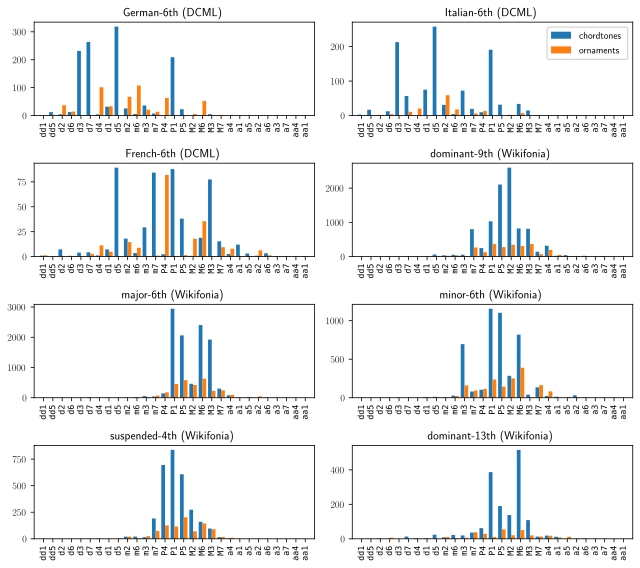

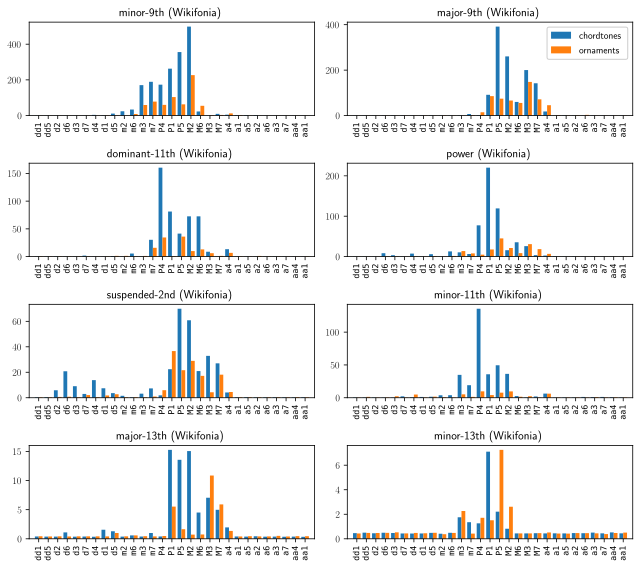

In [11]:
#plot remaining chords
def plot_rest_chords():
    rest_dcml = np.where(~(np.isin(dcml_chordtypes_alt, chordtypes_common)))[0]
    rest_wiki = np.where(~(np.isin(wiki_chordtypes_alt, chordtypes_common)))[0]
    
    #plot part 1
    fig1, axs1 = plt.subplots(4, 2, figsize=(9, 8))
    for i in range(3):
        ind = rest_dcml[i]
        plot_profile(axs1.flat[i], dcml_params, ind, dcml_chordtypes_alt[ind]+" (DCML)")
    for i in range(5):
        ind = rest_wiki[i]
        plot_profile(axs1.flat[i+3], wiki_params, ind, wiki_chordtypes_alt[ind]+" (Wikifonia)")
    axs1[0,1].legend(labels=['chordtones', 'ornaments'], framealpha=1)
    fig1.tight_layout()
    saveplot('chordtypes_rest1', fig1)
    
    # plot part 2
    fig2, axs2 = plt.subplots(4, 2, figsize=(9, 8))
    for i in range(8):
        ind = rest_wiki[i+5]
        plot_profile(axs2.flat[i], wiki_params, ind, wiki_chordtypes_alt[ind]+" (Wikifonia)")
    axs2[0,1].legend(labels=['chordtones', 'ornaments'], framealpha=1)
    fig2.tight_layout()
    saveplot('chordtypes_rest2', fig2)

plot_rest_chords()

In [13]:
def plot_profile_small(ax, params, i, name):
    chordtones = params['params_p_chordtones'][i]
    ornaments = params['params_p_ornaments'][i]
    labels = np.arange(-fifth_range, fifth_range+1)
    x = np.arange(2*fifth_range+1)
    vals = np.stack([-chordtones, ornaments])
    extr = max(chordtones.max(), ornaments.max())
    ax.imshow(vals, cmap="bwr", vmin=-extr, vmax=extr)
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    #ax.legend()